**классификатор текстов LSTM на Keras+TensorFlow**

Евгений Борисов <borisov.e@solarl.ru>

https://habr.com/ru/company/dca/blog/274027/    
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

## Библиотеки

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200  
import re
# import gzip
from tqdm import tqdm

In [2]:
tqdm.pandas()

In [3]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [4]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [5]:
data = pd.read_csv('../data/twit/positive.csv.gz',sep=';',header=None)
data.columns = ff
ppr(data)
data.sample(3)

записей: 114 911


,id,tdate,tmane,ttext,ttype,trep,tfav,tstcount,tfol,tfrien,listcount,unk
23568,409497106542764032,1386466692,tujipunikuf,"ща пошли тупые ники ""Рискни меня трахнуть"" я бы не рискнул=) или ""дрАчи в рАзетку"" с http://t.co/WJz2IAAoo5",1,0,0,0,475,147,144,0
70055,410465808532267008,1386697649,anutka_yats,"@botsmaaan видимо, сегодня все со стульев падают :)) особенно в каб. 130)",1,0,0,0,1077,36,36,0
58965,410135369385263104,1386618866,Sheva2506,"Идём значит в кино , порт сити )) Натахуй, я,Танюша, Санечка)))* http://t.co/PnppFJ2GMW",1,0,0,0,192,16,16,0


In [6]:
data = data[['id','ttext']]
data.sample(3)

,id,ttext
43048,409948048039477248,"@kaspibank поменяйте поставщика вот на этого, тогда будет всем хорошо) http://t.co/AN1xYNwcHQ Как раз названия схожие)"
17097,409367540201426946,"@ashvetsov Купил? :) Интересно, где в таких шляпках таксисты щеголяют?"
43964,409971564105707520,"Фильм ""Мой парень-псих"" лишний раз доказывает,что музыка-лучшее лекарство..))"


In [7]:
assert len(data['id']) == len(set(data['id']))

In [8]:
# data.dtypes

## очистка данных

In [9]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

100%|██████████| 114911/114911 [00:01<00:00, 81966.51it/s]


In [10]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [11]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 114911/114911 [00:01<00:00, 63968.43it/s]


In [12]:
data.sample(3)

,id,ttext,ttext_clean
44872,409980131705643008,@cyrus_aka_queen ахахах тут тож щас скандал был)\nну эт воще :D\nв пол двери такое написать..),"[cyrus, aka, queen, ахахах, тут, тож, щас, скандал, был, ну, эт, воще, happysmile, в, пол, двери, такое, написать]"
105092,411126935394471937,@stooneem ♥ты моя хорошая!!! Как же быстро летит время:),"[stooneem, ты, моя, хорошая, как, же, быстро, летит, время, happysmile]"
64946,410363889373945856,Ну а пока как обычно сижу очередь в банке передо мной человек 30 эт нормально),"[ну, а, пока, как, обычно, сижу, очередь, в, банке, передо, мной, человек, digit, эт, нормально]"


In [13]:
# удаление коротких слов
# data['ttext_clean'] = data['ttext_clean'].progress_apply(lambda t:[w for w in t if len(w)>2])

In [14]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 114 911
записей: 114 911


In [15]:
data.sample(3)

,id,ttext,ttext_clean
97198,411039230287429632,Лошадкаааааа :) с минус девяти в плюс шесть... #жесть как она есть http://t.co/ieGEIXXDZ8,"[лошадкаааааа, happysmile, с, минус, девяти, в, плюс, шесть, жесть, как, она, есть, url]"
60518,410280800773763072,так приятно когда идешь грызеш семечки и вдруг тебе попадается одна очищенная=),"[так, приятно, когда, идешь, грызеш, семечки, и, вдруг, тебе, попадается, одна, очищенная]"
39979,409903895629266944,"RT @bahhtee: Первый батл 2x2 на @slovoproject удачнее, чем на @versusbattleru - посмеялся от души))) После нашего с @a_borovik батла обнима…","[rt, bahhtee, первый, батл, на, slovoproject, удачнее, чем, на, versusbattleru, посмеялся, от, души, happysmile, после, нашего, с, a, borovik, батла, обнима]"


In [16]:
words = sorted(set.union( *data['ttext_clean'].apply(set) ))
voc = { w:i+1 for i,w in enumerate(words) }
voc['<pad>']= 0
ppr(voc)

записей: 166 099


In [17]:
# voc = sorted(set.union(*[ set(s) for s in data['ttext_clean'].values.tolist() ]))
# voc = { w:i+1 for i,w in enumerate(voc) }
# voc['<pad>']= 0
# ppr(voc)

In [18]:
# voc

## кодируем слова

In [19]:
data['code'] = data['ttext_clean'].progress_apply(lambda t: [ voc[w] for w in t] )

100%|██████████| 114911/114911 [00:00<00:00, 180191.28it/s]


In [20]:
data[['ttext','ttext_clean','code']].sample(3)

,ttext,ttext_clean,code
3135,@rin_nayeon омг почти 8 лет уже прошло Оо даже не верится),"[rin, nayeon, омг, почти, digit, лет, уже, прошло, оо, даже, не, верится]","[33559, 28172, 108106, 123027, 9280, 91065, 151949, 128339, 108236, 66727, 101792, 56955]"
60464,"Проснулась одна. Захожу на кухню, а там... Вот так подарочек) ну и как его не любить? http://t.co/Ch63W6zKpD","[проснулась, одна, захожу, на, кухню, а, там, вот, так, подарочек, ну, и, как, его, не, любить, url]","[127756, 107265, 78156, 98796, 89742, 45621, 146464, 60097, 146276, 117177, 104852, 79635, 82759, 72363, 101792, 92697, 41034]"
112337,"Когда Даша сегодня начала петь Лещенко на уроке,я точно поняла ,что я правильно определилась с подругами)","[когда, даша, сегодня, начала, петь, лещенко, на, уроке, я, точно, поняла, что, я, правильно, определилась, с, подругами]","[85633, 67080, 136624, 101572, 114876, 91206, 98796, 153429, 164868, 148988, 120748, 161033, 164868, 123329, 108618, 134675, 118068]"


In [21]:
# оценка размеров последовательнистей
data['code'].str.len().describe().astype(int)

count    114911
mean         13
std           4
min           1
25%          10
50%          13
75%          17
max          42
Name: code, dtype: int64

<AxesSubplot:ylabel='Frequency'>

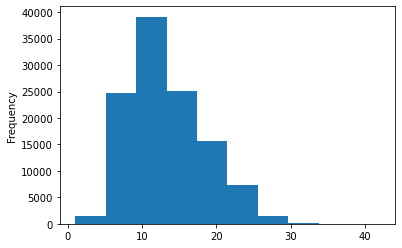

In [22]:
data['code'].str.len().plot.hist()

In [23]:
# максимальная длина
code_max_len = data['code'].str.len().max()
code_max_len

42

In [24]:
# дополняем короткие до максимальной длины
z = [0]*code_max_len
data['code'] = data['code'].progress_apply(lambda c: c+z[:(code_max_len-len(c))]  )

100%|██████████| 114911/114911 [00:00<00:00, 251717.43it/s]


In [25]:
data['code'].str.len().describe().astype(int)

count    114911
mean         42
std           0
min          42
25%          42
50%          42
75%          42
max          42
Name: code, dtype: int64

## строим датасет

In [26]:
# pair = data[['id','id']]
# pair.columns = ['id_l','id_r']
# pair

In [27]:
pair_neg = pd.DataFrame({
'id_L':data['id'].iloc[:-1].tolist(),
'id_R':data['id'].iloc[1:].tolist()
})

In [28]:
# НЕпохожие пары
pair_neg = pair_neg\
  .merge(data[['id','code']].rename(columns={'id':'id_L','code':'code_L'}), on=['id_L'] )\
  .merge(data[['id','code']].rename(columns={'id':'id_R','code':'code_R'}), on=['id_R'] )

pair_neg['target'] = 0
ppr(pair_neg)

записей: 114 910


In [29]:
pair_pos = pd.DataFrame({
'id_L':data['id'].tolist(),
'id_R':data['id'].tolist()
})

In [30]:
# похожие пары
pair_pos = pair_pos\
  .merge(data[['id','code']].rename(columns={'id':'id_L','code':'code_L'}), on=['id_L'] )\
  .merge(data[['id','code']].rename(columns={'id':'id_R','code':'code_R'}), on=['id_R'] )

pair_pos['target'] = 1
ppr(pair_pos)

записей: 114 911


In [31]:
cols = ['code_L','code_R','target']
dataset = pd.concat([
        pair_pos[cols],
        pair_neg[cols],
    ],axis=0).reset_index(drop=True)
ppr(dataset)

записей: 229 821


In [32]:
x_left  = np.vstack(dataset['code_L'].values)
x_right = np.vstack(dataset['code_R'].values)
target  = np.vstack(dataset['target'].values)

x_left.shape,x_right.shape,target.shape

((229821, 42), (229821, 42), (229821, 1))

In [33]:
# размер вектора OHE для embeding слоя
embed_input_dim = max([x_left.max(),x_right.max()]) + 1

In [34]:
x_left.shape, x_right.shape, target.shape, embed_input_dim

((229821, 42), (229821, 42), (229821, 1), 166099)

In [35]:
# переворачиваем последовательности (нули дополнения вначале, первое слово в конце)
x_left  = np.flip( x_left,  axis=1 )
x_right = np.flip( x_right, axis=1 )

In [36]:
# длина последовательности слов 
seq_len = x_left.shape[1]
seq_len

42

In [37]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [38]:
# отделяем тестовый набор
x_train, x_test, y_train, y_test = train_test_split( np.hstack([x_left,x_right]), target, test_size=.5)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((114910, 84), (114910, 1), (114911, 84), (114911, 1))

In [39]:
x_left_train, x_right_train = x_train[:,:seq_len],x_train[:,seq_len:]
y_train = y_train.flatten()
x_left_train.shape, x_right_train.shape, y_train.shape

((114910, 42), (114910, 42), (114910,))

In [40]:
x_left_test, x_right_test = x_test[:,:seq_len],x_test[:,seq_len:]
y_test = y_test.flatten()
x_left_test.shape, x_right_test.shape, y_test.shape

((114911, 42), (114911, 42), (114911,))

In [41]:
%xdel x_left
%xdel x_right
%xdel target

In [42]:
# gc.collect()

In [43]:
# y_train.sum()/len(y_train), y_test.sum()/len(y_test)

## модель

In [44]:
embed_len = 256
embed_input_dim, embed_len, seq_len

(166099, 256, 42)

In [46]:
from tensorflow import __version__ as tf_version
from tensorflow.keras import __version__ as keras_version
tf_version,keras_version

('2.4.1', '2.4.0')

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [48]:
from tensorflow_addons.losses import contrastive_loss

ModuleNotFoundError: No module named 'tensorflow_addons'

In [ ]:
embedding = Embedding(input_dim=embed_input_dim, input_length=seq_len, output_dim=embed_len, )
lstm = LSTM(embed_len,activation='relu') 

In [ ]:
# Конструирование левой ветви модели: 
input_l = Input( shape=(seq_len,), dtype='int32')
embedding_l = embedding(input_l)
lstm_l = lstm(embedding_l)

# Конструирование правой ветви модели: 
input_r = Input(shape=(seq_len,), dtype='int32')
embedding_r = embedding(input_r)
lstm_r = lstm(embedding_r)

# # Getting the L1 Distance between the 2 encodings
merged = Lambda(lambda t:K.abs(t[0]-t[1]),name='L1_distance')([lstm_l,lstm_r])

# Добавление классификатора
predictions = Dense(1, activation='sigmoid')(merged)

# Создание и обучение модели:
model = Model([input_l,input_r], predictions )

In [ ]:
plot_model(model,to_file=pjoin(FOLDER_RESULT,'model-embed-lstm.png'), 
           show_layer_names=True, show_shapes=True )
# model.summary()

In [ ]:
learning_rate = 9e-5
model.compile(loss=contrastive_loss, metrics=['acc',], optimizer=Adam(learning_rate))

In [ ]:
%%time

n_epochs = 2

history = model.fit( [x_left_train, x_right_train], y_train,
           epochs = n_epochs,
           batch_size = 4096,
           validation_split=.2,
         )

In [ ]:
with open( pjoin(FOLDER_RESULT,'model-embed-lstm.json'), 'wt') as f: f.write( model.to_json() )
model.save_weights( pjoin(FOLDER_RESULT,'model-embed-lstm-weights-%02d.h5'%(n_epochs) )) 

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import TensorBoard

#            callbacks=[
# #                        EarlyStopping(monitor='acc',baseline=.98, patience=2,), # restore_best_weights=True),
#                        TensorBoard(log_dir='./logs'),
#                      ],

----

In [ ]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()
plt.grid()

In [ ]:
plt.plot( np.array(history.history['acc']), label='train acc')
plt.plot( np.array(history.history['val_acc']), label='val acc')
plt.legend()
plt.grid()

In [ ]:
gc.collect()

## тест

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report

In [ ]:
def roc_auc_plot(y,p):
    fpr, tpr, thresholds = roc_curve( y, p )
    roc_auc = auc(fpr,tpr)

    plt.figure()
    plt.grid(True)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

---

In [ ]:
%%time 

p_train = model.predict([x_left_train, x_right_train])
accuracy_score( y_train, (p_train<.6) )

In [ ]:
pd.DataFrame(p_train).describe().T

In [ ]:
roc_auc_plot(y_train, 1.-p_train)

---

In [ ]:
%%time 

p_test = model.predict([x_left_test, x_right_test])
accuracy_score( y_test, (p_test<.6) )

In [ ]:
pd.DataFrame(p_test).describe().T

In [ ]:
roc_auc_plot(y_test, 1.-p_test)